<a href="https://colab.research.google.com/github/Kaiziferr/machine_learning/blob/main/metrics/roc_recall_precision_balanced_unbalanced_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    auc,
    precision_recall_curve
)

# **Config**
---


In [64]:
warnings.filterwarnings('ignore')
sns.set(style='darkgrid')
title_data = 'Diabetes'
paleta = sns.color_palette('tab10').as_hex()
random_seed = 12354

# **Funciones**
---

In [65]:
def generate_colors(paleta:str="Set1", n_colors:int=15)-> tuple:
  """color generator"""
  try:
    cmap = sns.color_palette(paleta, n_colors).as_hex()
    list_camp = ListedColormap(cmap)
    return cmap, list_camp
  except Exception as e:
    print(e)


def plot_bar(data:pd.DataFrame, paleta:list=None, figsize_x:int=8, figsize_y:int=5,
             fontsize:int=15, **kwards)->None:
  """Grafica un diagrama de barras con multiples caracteristicas"""
  try:
    paleta = paleta if paleta !=None else generate_colors()[0]
    v = kwards
    ejeX = v["ejeX"]

    fig, ax = plt.subplots(figsize = (figsize_x, figsize_y))
    fig.suptitle(f'Diagrama de barras {v["title"]}', fontsize=fontsize)

    if type(ejeX) == str:
      sns.countplot(x=ejeX, data=data, ax = ax, palette=paleta)
    else:
      ejeX = v['ejeX'][0]
      sns.countplot(x=ejeX, hue=v['ejeX'][1], data=data, ax=ax, palette=paleta)

    ax.set_ylabel(v['ejey'], size = 12)
    ax.set_xlabel(ejeX, size=fontsize-3)

    ax.set_xticklabels(ax.get_xticklabels(), fontsize = fontsize-3)
    for p in ax.patches:
      try:
        height = int(p.get_height())
        height_text = height
        if kwards['p'] == True:
          percentage = round(height/data.shape[0], 5)
          height_text = f'{height} ({percentage})'
        ax.text(p.get_x()+p.get_width()/2., height + 1, height_text, ha="center")
      except Exception as e:
        print(e)

  except Exception as e:
    print(e)

# **Generar Data  Balanced Data**
---

In [66]:
X, y = make_classification(
    n_samples = 1000,
    n_classes = 2,
    n_features = 8,
    n_redundant = 1,
    random_state=random_seed
    )

In [67]:
data = pd.DataFrame(X, columns=[f"c{i}" for i in range(8)])
data['c5'] = y

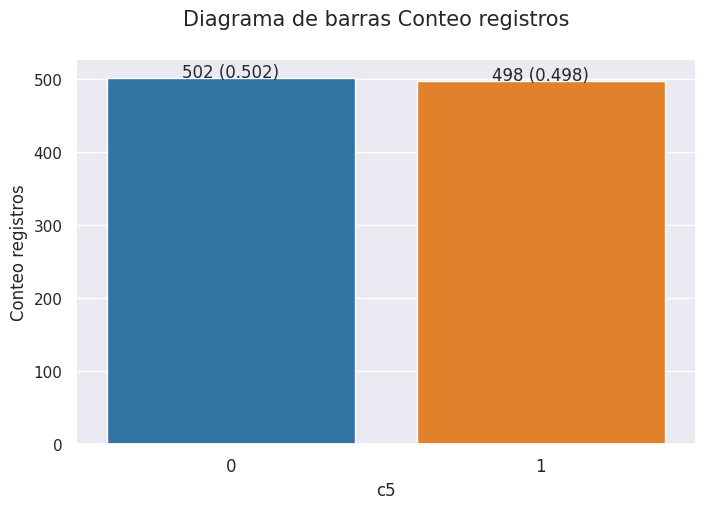

In [68]:
plot_bar(
    data,
    paleta=paleta,
    ejeX='c5',
    ejey='Conteo registros',
    title='Conteo registros', p=True)

- Los datos se encuentran balanceados.

## **Split**
---

In [69]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=0.5,
    random_state=random_seed
)

- **La data generada no requiere estandarizar**
- No se emplearan modelos tan complejos, ya que esto es un experimento

## **Model**
---

In [70]:
model = DecisionTreeClassifier(random_state=random_seed)

In [71]:
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': list(range(2, 8)),
    'min_samples_split': list(range(2, 8))
}

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    refit = True,
    return_train_score=True,
    cv=10,
)

In [72]:
grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=12354),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 3, 4, 5, 6, 7],
                         'min_samples_split': [2, 3, 4, 5, 6, 7]},
             return_train_score=True)

In [73]:
print('Mejor: %f usando %s' % (grid.best_score_, grid.best_params_))

Mejor: 0.914000 usando {'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 3}


In [74]:
model_tree = grid.best_estimator_
model_tree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 12354,
 'splitter': 'best'}

In [75]:
y_prob_tree = model_tree.predict_proba(X_test)
positive_case_prob_tree = y_prob_tree[:, 1]

# AUC
roc_auc_score_pc = roc_auc_score(y_test, positive_case_prob_tree)
print('DT: ROC AUC=%.3f' % (roc_auc_score_pc))

# ROC
fpr_tree, tpr_tree, umbrales = roc_curve(y_test, positive_case_prob_tree)


# Recall-Precision
precision_tree, recall_tree, thresholds_tree = precision_recall_curve(y_test, positive_case_prob_tree)

# AUC Recall-Precision
auc_score_tree = auc(recall_tree, precision_tree)
print('DT: ROC AUC PRECISION RECALL=%.3f' % (auc_score_tree))

DT: ROC AUC=0.942
DT: ROC AUC PRECISION RECALL=0.956


In [76]:
model_lg = LogisticRegression(solver='lbfgs')
model_lg.fit(X_train, y_train)

y_prob_lg  = model_lg.predict_proba(X_test)
positive_case_prob_lg = y_prob_lg[:, 1]

# AUC
roc_auc_score_lg = roc_auc_score(y_test, positive_case_prob_lg)
print('lg: ROC AUC=%.3f' % (roc_auc_score_lg))

# ROC
fpr_lg, tpr_lg, umbrales = roc_curve(y_test, positive_case_prob_lg)


# Recall-Precision
precision_lg, recall_lg, thresholds_lg = precision_recall_curve(y_test, positive_case_prob_lg)

# AUC Recall-Precision
auc_score_lg = auc(recall_lg, precision_lg)
print('lg: ROC AUC PRECISION RECALL=%.3f' % (auc_score_lg))

lg: ROC AUC=0.950
lg: ROC AUC PRECISION RECALL=0.963


In [77]:
model_dummy = DummyClassifier()
model_dummy.fit(X_train, y_train)

y_prob_dummy  = model_dummy.predict_proba(X_test)
positive_case_prob_dummy = y_prob_dummy[:, 1]

# AUC
roc_auc_score_dummy = roc_auc_score(y_test, positive_case_prob_dummy)
print('Dummy: ROC AUC=%.3f' % (roc_auc_score_dummy))

# ROC
fpr_dummy, tpr_dummy, umbrales = roc_curve(y_test, positive_case_prob_dummy)


# ROC
fpr_dummy, tpr_dummy, umbrales = roc_curve(y_test, positive_case_prob_dummy)


# Recall-Precision
precision_dummy, recall_dummy, thresholds = precision_recall_curve(y_test, positive_case_prob_dummy)

# AUC Recall-Precision
auc_score_dummy = auc(recall_dummy, precision_dummy)
print('Dummy: ROC AUC PRECISION RECALL=%.3f' % (auc_score_dummy))

Dummy: ROC AUC=0.500
Dummy: ROC AUC PRECISION RECALL=0.739


In [78]:
y_prob_no_sklill = [0 for _ in range(len(y_test))]
roc_auc_score_no_skill = roc_auc_score(y_test, y_prob_no_sklill)
# AUC
print('No skill: ROC AUC=%.3f' % (roc_auc_score_no_skill))


# ROC
fpr_nkill, tpr_nkill, umbrales_nkill = roc_curve(y_test, y_prob_no_sklill)

No skill: ROC AUC=0.500


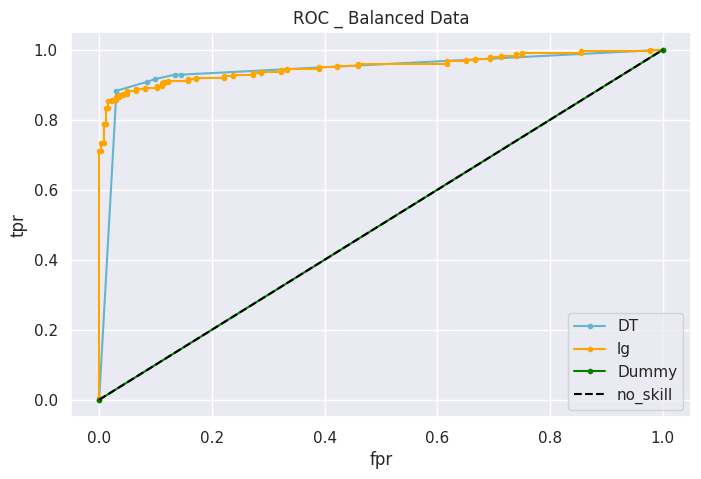

In [79]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
plt.plot(fpr_tree, tpr_tree, marker='.', label='DT', color = 'c')
plt.plot(fpr_lg, tpr_lg, marker='.', label='lg', color = 'orange')
plt.plot(fpr_dummy, tpr_dummy, marker='.', label='Dummy', color = 'green')
plt.plot(fpr_nkill, tpr_nkill, linestyle='--', label='no_skill', color = 'black')
plt.title('ROC _ Balanced Data')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()
plt.show()

Los modelos de árbol de decisión y regresión logística, tienen bajos niveles de falsos negativos y de falsos positivos, lo que indican un buen rendimiento en la precisión de la clase de interés, además como la tasa de falsos positivos es baja, los modelos tienen un buen comportamiento con respecto a la clase de no interés también.

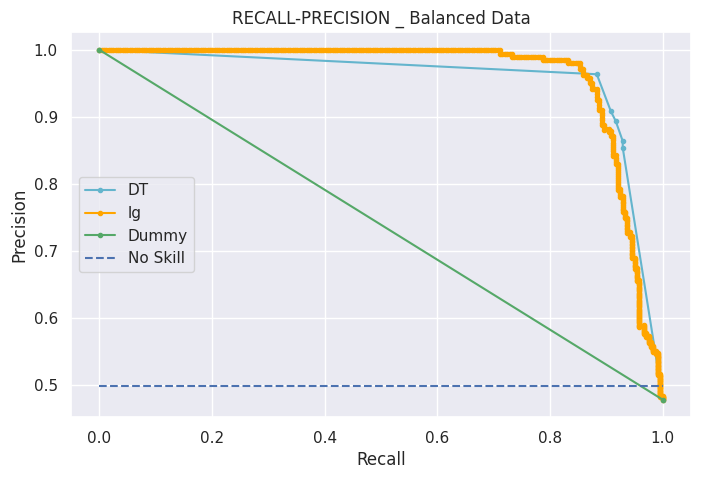

In [80]:
no_skill_curve_recall_presicion = len(y[y==1]) / len(y)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
plt.plot(recall_tree, precision_tree, marker='.', label='DT', color = 'c')
plt.plot(recall_lg, precision_lg, marker='.', label='lg', color = 'orange')
plt.plot(recall_dummy, precision_dummy, marker='.', label='Dummy', color = 'g')
plt.plot(
    [0, 1],
     [no_skill_curve_recall_presicion, no_skill_curve_recall_presicion],
    linestyle='--', label='No Skill')
plt.title('RECALL-PRECISION _ Balanced Data')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# **Generar Data  Unbalanced Data**
---

In [81]:
X, y = make_classification(
    n_samples = 1000,
    n_classes = 2,
    n_features = 8,
    n_redundant = 1,
    weights=[0.99, 0.01],
    random_state=random_seed
    )

In [82]:
data = pd.DataFrame(X, columns=[f"c{i}" for i in range(8)])
data['c5'] = y

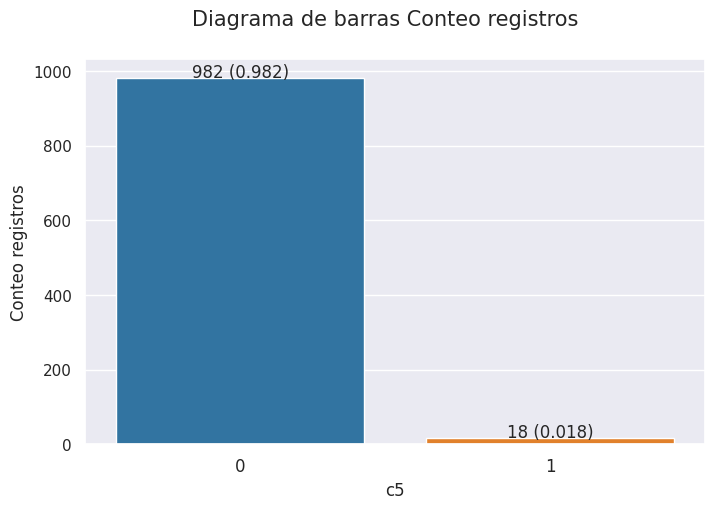

In [83]:
plot_bar(
    data,
    paleta=paleta,
    ejeX='c5',
    ejey='Conteo registros',
    title='Conteo registros', p=True)

## **Split**
---

In [84]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=0.7,
    random_state=random_seed,
    stratify=y
)

- **La data generada no requiere estandarizar**
- No se emplearan modelos tan complejos, ya que esto es un experimento

## **Model**
---

In [85]:
model = DecisionTreeClassifier(random_state=random_seed)

In [86]:
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': list(range(2, 8)),
    'min_samples_split': list(range(2, 8))
}

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    refit = True,
    return_train_score=True,
    cv=10,
)

In [87]:
grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=12354),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 3, 4, 5, 6, 7],
                         'min_samples_split': [2, 3, 4, 5, 6, 7]},
             return_train_score=True)

In [88]:
print('Mejor: %f usando %s' % (grid.best_score_, grid.best_params_))

Mejor: 0.988571 usando {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 2}


In [89]:
model_tree = grid.best_estimator_
model_tree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 2,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 12354,
 'splitter': 'best'}

In [90]:
y_prob_tree = model_tree.predict_proba(X_test)
positive_case_prob_tree = y_prob_tree[:, 1]

# AUC
roc_auc_score_pc = roc_auc_score(y_test, positive_case_prob_tree)
print('DT: ROC AUC=%.3f' % (roc_auc_score_pc))

# ROC
fpr_tree, tpr_tree, umbrales = roc_curve(y_test, positive_case_prob_tree)


# Recall-Precision
precision_tree, recall_tree, thresholds_tree = precision_recall_curve(y_test, positive_case_prob_tree)

# AUC Recall-Precision
auc_score_tree = auc(recall_tree, precision_tree)
print('DT: ROC AUC PRECISION RECALL=%.3f' % (auc_score_tree))

DT: ROC AUC=0.789
DT: ROC AUC PRECISION RECALL=0.568


In [91]:
model_lg = LogisticRegression(solver='lbfgs')
model_lg.fit(X_train, y_train)

y_prob_lg  = model_lg.predict_proba(X_test)
positive_case_prob_lg = y_prob_lg[:, 1]

# AUC
roc_auc_score_lg = roc_auc_score(y_test, positive_case_prob_lg)
print('lg: ROC AUC=%.3f' % (roc_auc_score_lg))

# ROC
fpr_lg, tpr_lg, umbrales = roc_curve(y_test, positive_case_prob_lg)


# Recall-Precision
precision_lg, recall_lg, thresholds_lg = precision_recall_curve(y_test, positive_case_prob_lg)

# AUC Recall-Precision
auc_score_lg = auc(recall_lg, precision_lg)
print('lg: ROC AUC PRECISION RECALL=%.3f' % (auc_score_lg))

lg: ROC AUC=0.745
lg: ROC AUC PRECISION RECALL=0.352


In [92]:
model_dummy = DummyClassifier()
model_dummy.fit(X_train, y_train)

y_prob_dummy  = model_dummy.predict_proba(X_test)
positive_case_prob_dummy = y_prob_dummy[:, 1]

# AUC
roc_auc_score_dummy = roc_auc_score(y_test, positive_case_prob_dummy)
print('Dummy: ROC AUC=%.3f' % (roc_auc_score_dummy))

# ROC
fpr_dummy, tpr_dummy, umbrales = roc_curve(y_test, positive_case_prob_dummy)


# ROC
fpr_dummy, tpr_dummy, umbrales = roc_curve(y_test, positive_case_prob_dummy)


# Recall-Precision
precision_dummy, recall_dummy, thresholds = precision_recall_curve(y_test, positive_case_prob_dummy)

# AUC Recall-Precision
auc_score_dummy = auc(recall_dummy, precision_dummy)
print('Dummy: ROC AUC PRECISION RECALL=%.3f' % (auc_score_dummy))

Dummy: ROC AUC=0.500
Dummy: ROC AUC PRECISION RECALL=0.508


In [93]:
y_prob_no_sklill = [0 for _ in range(len(y_test))]
roc_auc_score_no_skill = roc_auc_score(y_test, y_prob_no_sklill)
# AUC
print('No skill: ROC AUC=%.3f' % (roc_auc_score_no_skill))


# ROC
fpr_nkill, tpr_nkill, umbrales_nkill = roc_curve(y_test, y_prob_no_sklill)

No skill: ROC AUC=0.500


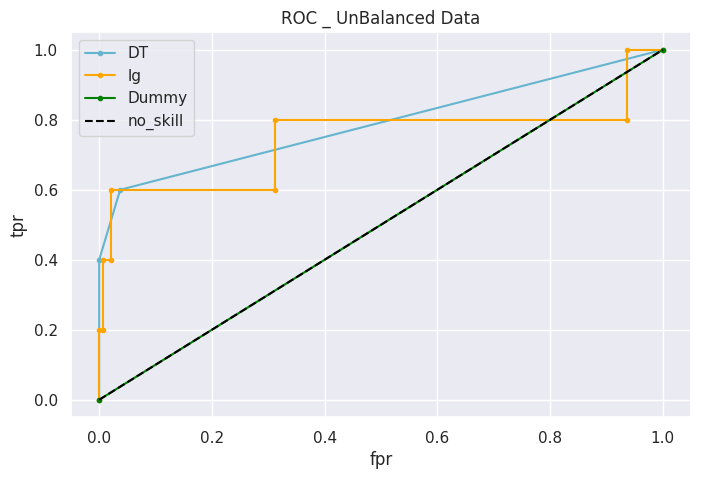

In [94]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
plt.plot(fpr_tree, tpr_tree, marker='.', label='DT', color = 'c')
plt.plot(fpr_lg, tpr_lg, marker='.', label='lg', color = 'orange')
plt.plot(fpr_dummy, tpr_dummy, marker='.', label='Dummy', color = 'green')
plt.plot(fpr_nkill, tpr_nkill, linestyle='--', label='no_skill', color = 'black')
plt.title('ROC _ UnBalanced Data')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()
plt.show()

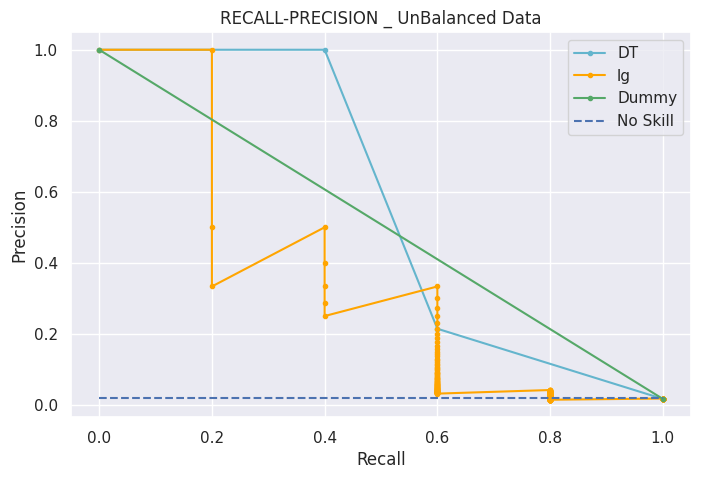

In [95]:
no_skill_curve_recall_presicion = len(y[y==1]) / len(y)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
plt.plot(recall_tree, precision_tree, marker='.', label='DT', color = 'c')
plt.plot(recall_lg, precision_lg, marker='.', label='lg', color = 'orange')
plt.plot(recall_dummy, precision_dummy, marker='.', label='Dummy', color = 'g')
plt.plot(
    [0, 1],
     [no_skill_curve_recall_presicion, no_skill_curve_recall_presicion],
    linestyle='--', label='No Skill')
plt.title('RECALL-PRECISION _ UnBalanced Data')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()